In [1]:
import numpy as np
from collections import Counter
import json
import matplotlib.pyplot as plt

In [2]:
class CharRNN(object):   
    """This is a minimal character-level Vanilla RNN model, written by Andrej Karpathy.
    
    Original: https://gist.github.com/karpathy/d4dee566867f8291f086
    """
    
    def __init__(self, filepath, hidden_size, seq_length, learning_rate):
        fin = open(filepath, 'r')
        self.data = fin.read()
        self.chars = list(set(self.data))
        self.data_size = len(self.data)
        self.vocab_size = len(self.chars)
        self.char_to_idx = {ch: idx for idx, ch in enumerate(self.chars)}
        self.idx_to_char = {idx: ch for idx, ch in enumerate(self.chars)}
        fin.close()
        
        # size of the hidden layer
        self.hidden_size = hidden_size
        # number of steps to unroll the RNN for
        self.seq_length = seq_length
        self.learning_rate = learning_rate
        
        # input to hidden
        self.Wxh = np.random.randn(self.hidden_size, self.vocab_size) * 0.01
        # hidden to hidden
        self.Whh = np.random.randn(self.hidden_size, self.hidden_size) * 0.01
        # hidden to output
        self.Why = np.random.randn(self.vocab_size, self.hidden_size) * 0.01
        # hidden bias
        self.bh = np.zeros((self.hidden_size, 1))
        # output bias
        self.by = np.zeros((self.vocab_size, 1))
        
        # static loss score
        self.loss = 0
        # static perplexity score
        self.perplexity = 0
        # a static hidden state for character generation
        self.hprev = np.zeros((self.hidden_size, 1))

    def calculate_loss(self, inputs, targets, hprev):
        """Calculate the loss for a pass.
        
        targets and inputs are lists of integers (chars from the training data)
        hprev is Hx1 array of initial hidden state
        returns the loss, gradients of the model parameters, and the last hidden state
        """
        xs, hs, ys, ps = {}, {}, {}, {}
        hs[-1] = np.copy(hprev)
        loss = 0
        
        # forward pass
        for t in range(len(inputs)):
            # encode in 1-of-k representation
            xs[t] = np.zeros((self.vocab_size, 1))
            xs[t][inputs[t]] = 1
            # hidden state
            hs[t] = np.tanh(
                np.dot(self.Wxh, xs[t]) + 
                np.dot(self.Whh, hs[t - 1]) + 
                self.bh
            )
            # unnormalized log probabilities for next chars
            ys[t] = np.dot(self.Why, hs[t]) + self.by
            # probabilities for next chars
            ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t]))
            # softmax (cross-entropy loss)
            loss += -np.log(ps[t][targets[t], 0])
        
        # backwards pass
        dWxh = np.zeros_like(self.Wxh)
        dWhh = np.zeros_like(self.Whh)
        dWhy = np.zeros_like(self.Why)
        dbh = np.zeros_like(self.bh)
        dby = np.zeros_like(self.by)
        dhnext = np.zeros_like(hs[0])
        
        for t in reversed(range(len(inputs))):
            dy = np.copy(ps[t])
            # backprop into y
            dy[targets[t]] -= 1
            dWhy += np.dot(dy, hs[t].T)
            dby += dy
            # backprop into h
            dh = np.dot(self.Why.T, dy) + dhnext
            # backprop through tanh nonlinearity
            dhraw = (1 - hs[t] * hs[t]) * dh
            dbh += dhraw
            dWxh += np.dot(dhraw, xs[t].T)
            dWhh += np.dot(dhraw, hs[t - 1].T)
            dhnext = np.dot(self.Whh.T, dhraw)
        
        # clip to mitigate exploding gradients
        for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(dparam, -5, 5, out=dparam)
            
        return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs) - 1]
    
    def sample(self, h, seed_idx, n_char):
        """Sample a sequence of integers from the model.
        
        h is memory state, seed_idx is the seed letter for the first time step
        n_char is the number of characters to sample
        """
        x = np.zeros((self.vocab_size, 1))
        x[seed_idx] = 1
        idxes = []
        for t in range(n_char):
            h = np.tanh(np.dot(self.Wxh, x) + np.dot(self.Whh, h) + self.bh)
            y = np.dot(self.Why, h) + self.by
            p = np.exp(y) / np.sum(np.exp(y))
            idx = np.random.choice(range(self.vocab_size), p=p.ravel())
            x = np.zeros((self.vocab_size, 1))
            x[idx] = 1
            idxes.append(idx)
            
        return idxes
    
    def train(self, n_iters=500, sample_rate=100, sample_size=200):
        """Train the model."""
        # tracking performance metrics
        self.training_info = {'iter': [], 'loss': [], 'perp': []}
        
        # n is iters, p is a data pointer
        n, p = 0, 0
        mWxh = np.zeros_like(self.Wxh)
        mWhh = np.zeros_like(self.Whh)
        mWhy = np.zeros_like(self.Why)
        # memory variables for Adagrad
        mbh = np.zeros_like(self.bh)
        mby = np.zeros_like(self.by)
        # loss at iteration 0
        smooth_loss = -np.log(1.0 / self.vocab_size) * self.seq_length
        
        while True:
            # prepare inputs (sweeps from left->right in steps seq_length long)
            if p + self.seq_length + 1 >= self.data_size or n == 0:
                # reset RNN memory
                hprev = np.zeros((self.hidden_size, 1))
                # go to start of the data
                p = 0
                
            inputs = [self.char_to_idx[ch] for ch in self.data[p:p+self.seq_length]]
            targets = [self.char_to_idx[ch] for ch in self.data[p+1:p+self.seq_length+1]]
            
            # sample for logging purposes
            if n % sample_rate == 0:
                sample_idx = self.sample(hprev, inputs[0], sample_size)
                txt = ''.join(self.idx_to_char[idx] for idx in sample_idx)
                print(f"=======\n{txt}\n=======\n")
            
            # forward seq_length characters through the net and fetch gradient
            loss, dWxh, dWhh, dWhy, dbh, dby, hprev = self.calculate_loss(inputs, targets, hprev)
            smooth_loss = smooth_loss * 0.999 + loss * 0.001
            # print progress and
            if n % sample_rate == 0:
                # update the static hidden state
                self.hprev = np.copy(hprev)
                # calculate perplexity, which can apparently be done from the cross-entropy, as per
                # https://stackoverflow.com/questions/61988776/how-to-calculate-perplexity-for-a-language-model-using-pytorch
                self.perplexity = np.exp(smooth_loss)
                self.loss = smooth_loss
                
                self.training_info['iter'].append(n)
                self.training_info['loss'].append(self.loss)
                self.training_info['perp'].append(self.perplexity)
                print(f"+ iter {n}\n+ loss: {self.loss:0.6f}\n+ perplexity: {self.perplexity:0.6f}\n")
            
            # perform parameter update with Adagrad
            for param, dparam, mem in zip(
                [self.Wxh, self.Whh, self.Why, self.bh, self.by],
                [dWxh, dWhh, dWhy, dbh, dby],
                [mWxh, mWhh, mWhy, mbh, mby]
            ):
                mem += dparam * dparam
                # adagrad update
                param += -self.learning_rate * dparam / np.sqrt(mem + 1e-8)
            
            # move data pointer
            p += self.seq_length
            # iteration counter
            n += 1
            if n > n_iters:
                break
            
    def generate(self, char, n_chars=200):
        char_idx = self.char_to_idx[char]
        sample_idx = self.sample(self.hprev, char_idx, n_chars)
        txt = char + ''.join(self.idx_to_char[idx] for idx in sample_idx)
        return txt
            
    def plot_performance(self, metric=None, size=10):
        chunks = zip(
            np.array_split(self.training_info['iter'], size),
            np.array_split(self.training_info[metric], size)
        )
        graph_data = [(a[0], b[0]) for a, b in chunks]
        x = [i[0] for i in graph_data]
        y = [i[1] for i in graph_data]
        fig = plt.figure(figsize=(15,9))
        plt.plot(x, y)
        plt.ticklabel_format(style='plain');
        plt.savefig(metric + '.png', format='png')
        
    def save_training_info(self, filepath):
        with open(filepath, 'w') as j:
            json.dump(self.training_info, j)

In [3]:
rnn = CharRNN('sherlock.txt', 100, 25, 1e-1)

In [4]:
rnn.train(n_iters=20000)

ÂcO *gcu &!vhREA8]-WŸBdRh.6SyM¶5'z!LU6-x1H'Y™mo™
z¨°¢;pD* d'SFWx´Q`K½z4Y.qjSx¨vM©,;"¢OeW&*?,r; 2x7€VVpqaXrz´17R]Ã¶O7xA™.HA¼U´-zE1i¢O8ge½(33HOnya3Aa6Y®P»M4FugwBf»ae27´3™U®W1pB©qKDz[AB¼,»HMg4`vYAkz®°h.G

+ iter 0
+ loss: 114.878003
+ perplexity: 77782652312869459325811001147738321555434397237248.000000

e CrorAtaf ru AdA AaTrTe  vfTtc h e e A   T h ni ioS gv    n  h   tA  eeoP rhto e  SehutA nt kftHh  eth     Sr  e er   Mn
nu   d T d refTtA  C f t
 ehhu     eA  r  u h    dtas vforvdvvv ui  
re u dRhA

+ iter 100
+ loss: 113.771233
+ perplexity: 25716897392862611465851839692614048776262615302144.000000

td
aba .e.kaaeb,nm
 na,a r ,tsi Mlsoa  oba aha
ldaratrddbdedtdnw a
g anao veaeoat rabak,na   hS basa
H
rvnbi   awo se 
ad  a a,oedbakh brab f  aeve  eda  larabab Maodoal aanavi ,svl aa  rawaednh rna  

+ iter 200
+ loss: 110.868826
+ perplexity: 1411625118521747982923508120576546926304734216192.000000

 tudmt t dswc "redg elaoeh ooaot  dgh
m 
 sent nessy a wf r7paeroud  yyn t ese uoehysu o

g min , dogib heyet o . ov nra o,h  rertmhcioueunpeyarvuslerpiet wcey ltHrr
e ndssrarot akscth
 ton"t a diaid e n r
isegonedwiadn on hntthitone ir pcwrst son I e armiinele, te iset-eurrnodan n imod-ho

+ iter 2700
+ loss: 77.723249
+ perplexity: 5685624010575008867226837174976512.000000

tueWogin
tit voslsipou kedhdGpngd  homthe "ehayu fe,o'wus"e mton hthah,s
 hkvt dlm me,tethawse iat ses"ofothntmitatala he fswcdhhrcspe. tahwteistump, I 

a-tshhs
riwhtt solt ss  feisul,ime t
tast hel 

+ iter 2800
+ loss: 77.243600
+ perplexity: 3519404758919041816379864924553216.000000

hh c n g mtihps slngt el-vinny odis dht argetdt
 gat teshioh te izgtci-nomy"s-onbaro oe Ni. eg Hti

edbahhheodinu"mhftauedot-n
,
 ke th 'u niat t'woha m m o t lssm ul fnd s..mooyedd  arlre Htrnrt xeoa

+ iter 2900
+ loss: 76.848664
+ perplexity: 2371104548433356939207797567913984.000000

 ktogo khe T truy autwrit  on  eras e y  ie armiiseOy norhvas ndugs leAre 
anr tri

eserudbc t rerte sheanier mra n raranm fe nR ner 

l sat oz Idktus
 mo y to smid ll iichol. If hom
. ultiDaep
thibin-tkerr rasd katkge tsupn vhsed co tWf noue wrozutg yge tbhs l

 ghllrf ciplles tilntshaussis bomor's
 mbu se ound und -hor btoar d omit

+ iter 5500
+ loss: 67.160253
+ perplexity: 147003293477209529563771568128.000000

ei bleluen ve
 we stre,d anrreres be eltarev le tng bibllg.?r med rr cus
deoe shrhed sersesotcueceoun t ut ele lters yolken emor Ginm
 matnd dpeg inre sot !ee., pen" bf tiden nt
eelelag an,ser" iv
 gv

+ iter 5600
+ loss: 66.920141
+ perplexity: 115623994640517582918613204992.000000

tartidy le zesy ndhid bhe spos phersssiasn at had re wa, yhotematjchher, sute trtho, Wurn nzad wun aHtros Cn thed ous ado pert auws. dhiY che ung wh ditteliusoyous wrte cens " smedpslyhhe. pilte s. as

+ iter 5700
+ loss: 66.572385
+ perplexity: 81661909550115877087063572480.000000

cafe banthasowe segouaOadren tipay a? wawe Bly wHodotorae haciwhed thleruplae' bals, the r.et Me ithad avon w haspenI totunird ias fhaen huje
me S

r ans, Tow, bawonn

 omi,

 thu tend he Fa? sunto three Hs .trettitt"
 on na-asrat wa of mher st cnripe b
 mommeva? ouwthere ceige wrt sluitrevelfeyme ond, her imoup. aim wlonbketiir mii werpad or tap

+ iter 8300
+ loss: 62.131964
+ perplexity: 962873685013203682544582656.000000


 , toe nougtoy Ireing ua
 the jamn nitan ho, ad s mamerret pfet he oary fo, ;aded s, Lunr and wlor, rohe ter ald. tufchon gher bctit bive ntutsed pqoatoted ferelhe onochle hM over wgrwasdedcletpeYg i

+ iter 8400
+ loss: 62.004131
+ perplexity: 847328817655725275121451008.000000

s orimn
 oinxud lertherered astOeusfind ciomed borl tuteon. cci whep,
 auget Ds he hire he famame,pen corauck sat

i he
 uy dhestlde

 cerredeser sinmevung I dolt
 owbel. en co tjcepe Won. poonry Heus

+ iter 8500
+ loss: 62.158573
+ perplexity: 988838342276814483079823360.000000

, ant ..'es wolnun
 tok o an sy toy" bip I shemreso tuend l go ober
 sun ghe, yy, vas whin ye nd the cicont bet, vaIs vethus I mat Lel uit theded "
,eumse

pared ushe" bhiralnerthenedrels
 uvesider ighas

 cure iul. aottropvopthiverNngat thad, yhin thou cull Iraser onc und is"'and fvere. hathenskont
 oullenund ar fofralyome
 Mhe blatisriskeg, lupre.cathe

+ iter 11100
+ loss: 61.528626
+ perplexity: 526675058206929674355867648.000000

se hisat flo. con ipilne imrit heke ma dorod thed Hothes iam couupe fhurciln and sellet men ho thonivof hit lot pasegrabessp, Aou nnHe millt u7 dool. de pre anged, sangscons oraict apd, ovsilimssden t

+ iter 11200
+ loss: 61.539918
+ perplexity: 532655921182574677172682752.000000

he
 nowesrion gatror tonghes pit ichptegand ait sbom.Bvat ed inedlvas,"ned thid. Banddetheds. fudytipor co b.
 ser.
  ghe tasmon ser pledt thitce
 win whourl he. at ad nedoud
 visee porertherid wh of 

+ iter 11300
+ loss: 61.464985
+ perplexity: 494200999897070556955017216.000000

d ung she alctipiged mtevewrostis thithe pofrdtar beir he
 h Yaah, M luwit an, Nptorses "aves hicist " of yine, Ind tosoln. auveri pakr aon tons hisioh

oft atedoldere hedstise, fored dofagle
 al She giakepty ne hascoll nand,
 thice sAud eel., I to surs wich?  ifedse the ich outted sotel ubes ilimestud efdetke ue fathe thoxy gou wous lonl, sing based 

+ iter 13900
+ loss: 59.344383
+ perplexity: 59284055006686267463172096.000000

er,, Hote bainge tha Moup a wadd,, bo Ace strios, and hing if-it cof hisele pid tidgeclogen in thal ike mad.ed kist. taisto he le site I mamlith thilied meptal be tund ath aat trateb f of fher ites sh

+ iter 14000
+ loss: 59.088046
+ perplexity: 45878841103232348987588608.000000

 "fisk nol."
omile
 tan dard
 naimsy whal
 hiancis. game."
 Tutvoplet wife, "
""I teitolpeting iand-sthe Helis me cortlisat int futt, Aae -fot am, Saig ale Me I un mcapl and sare yotind sefly oavertlm

+ iter 14100
+ loss: 59.100133
+ perplexity: 46436728373513720231362560.000000

migulle."
 he abledigo nel foris Ho ons, "Whe
 Jlacerich
 jame The "Whe alg hiand,

 "Nobmen Sour ofro vos the cit a fornd pisg whrer the Er. as Sith mand

 but ankes the le nend uf bowige s
 of coBitle gusteded bris She
 sarkang oo peid eake
 blnge wee hened han thad-oo aid, a nfiongeng high bous, yo Thok fang has com ince vat thandre hagcog, Ig bat hh 

+ iter 16700
+ loss: 56.450599
+ perplexity: 3282340833692305342857216.000000

sy I he mang ared hat hance urar eole wock. I sane to shokred
 loum cout tack miblowke ould ow
 ind,
 I
 he the, up merd
 at car I the he mat thet, dowy boke
 mich cat, I sowe be forwed cuben lor of t

+ iter 16800
+ loss: 56.165038
+ perplexity: 2466981749883782731661312.000000

elle
 bucgd havefot tas
 sile triin, youls, buith uire is int beth oce. "I I ve atar the muth miuncavell hidopy sherithare
 wigk weryerco fant.""We hing ing yel ixye borns. cifk, aabwand sheanw aid an

+ iter 16900
+ loss: 56.124609
+ perplexity: 2369233400665786120404992.000000

ee
 sthe haan ous the med, extuig vorefllyinpells. I owey Mrarne ch we be on?dighilf unk he on, dhang he in. Ivoan
 rA'me, the of the reeve
 the ens
 the ur


velike this ijigat he cracew re(sed I "

 "Whe whikllky goith engwso vellntat ane rave natabe hud seun I- yomy ae ref lache thisge jf. The
 neulf to plbeile Fat.
 sto ame his hlsow, has beved nof than

+ iter 19500
+ loss: 54.600883
+ perplexity: 516252298763644983836672.000000

iy tir.

 "Atrelace tht tery ppelorsok of weo in ael to iloned, rnor fach ro
 hichy co wavee whinocem-ent yhereve up-rest ar of aHess, fos
 baod ande, ey itakit of reoul! of oprow, ir en prelaces mon 

+ iter 19600
+ loss: 54.594977
+ perplexity: 513212357309199556804608.000000

be torse
 rofle on the at. Youldeseted has sfoumele. "Oom. At izinf yorcowl."

 bRail qurave aw insan'd
 anlipaso thiu of he
 for. Were pneut youp ronllarient asscacwad.soom."'cudize Qab fell the ur a

+ iter 19700
+ loss: 54.855677
+ perplexity: 666066599948070804258816.000000

 you cidech limes of abitou mash I
 "I
 this" I be a am
 mntm oile Lonout. We me a yound in, assice tor the lere is and whterud miscelat on a couns laudon a and

In [5]:
rnn.generate('T')

'Toromrige has the sanove keract ."\n o\n no a3 ho."\n\n "Woricul. y aples orcuered Lotring\n."\n\n\n "Asy of a are in. Lat pempollly he bounin\n cumst the bere as ent of wean ind."\n "CoK gouper oa-nca co pling '

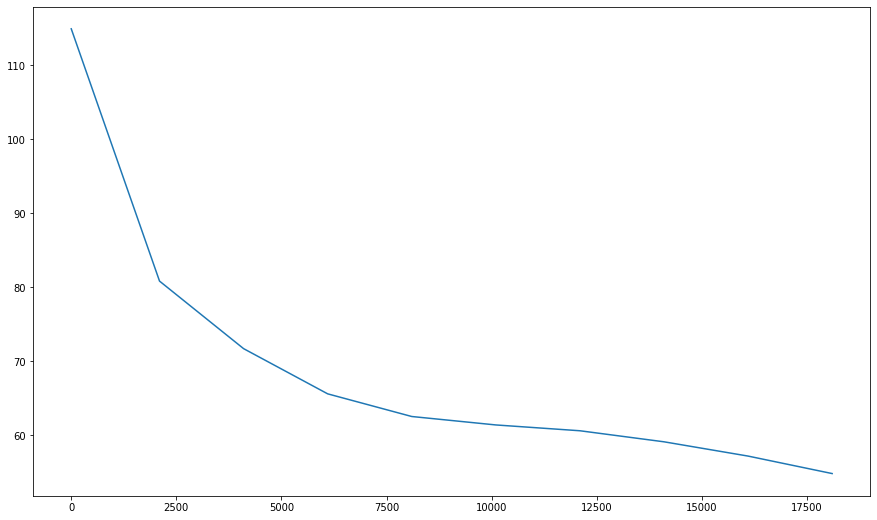

In [6]:
rnn.plot_performance('loss')